# Names: Aron Calvert (22370374), Leo O'Shea (22342761)
# Code runs to completion: YES
# Third-party source reused: https://www.kaggle.com/datasets/puneet6060/intel-image-classification

# Import and load in data from Kaggle

In [ ]:
# Import and mount drive

import tensorflow as tf

from google.colab import files

# used as pipeline
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# keras imports used for building the CNN
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, GlobalAveragePooling2D, Activation, Dropout

from tensorflow.keras.losses import CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam, SGD

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# For charts, graphs and visualisations
import matplotlib.pyplot as plt
import os
from PIL import Image
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

from tensorflow.keras.models import load_model

In [ ]:
# upload kaggle.json, download, unzip data etc

files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d puneet6060/intel-image-classification
!unzip -q intel-image-classification.zip

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/puneet6060/intel-image-classification
License(s): copyright-authors
 98% 338M/346M [00:00<00:00, 1.77GB/s]
100% 346M/346M [00:00<00:00, 1.77GB/s]


# Data Set visualisation

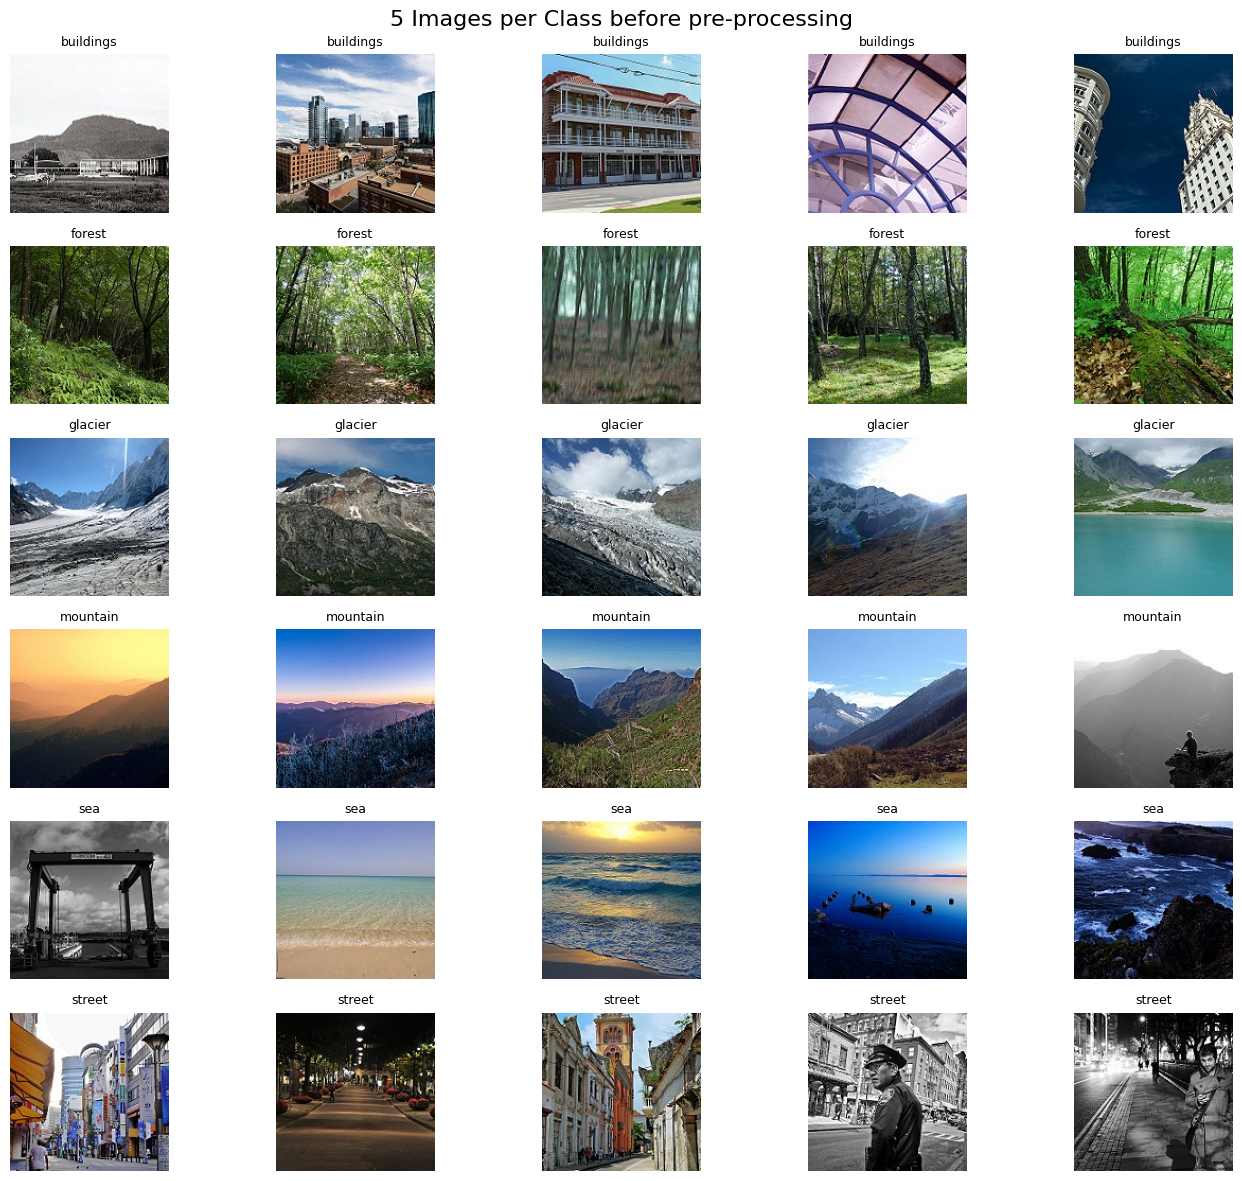

In [ ]:
# 5 image per class

DATA_DIR = "seg_train/seg_train"

classes = sorted(os.listdir(DATA_DIR))

plt.figure(figsize=(14, 12))

for i, cls in enumerate(classes):
    class_dir = os.path.join(DATA_DIR, cls)
    image_files = sorted(os.listdir(class_dir))[:5]

    for j, img_name in enumerate(image_files):
        img = Image.open(os.path.join(class_dir, img_name)).convert("RGB")

        plt.subplot(len(classes), 5, i*5 + j + 1)
        plt.imshow(img)
        plt.title(cls, fontsize=9)
        plt.axis("off")

plt.suptitle("5 Images per Class before pre-processing", fontsize=16)
plt.tight_layout()
plt.show()


In [ ]:
# prepare data for visualisations!

DATA_DIR = "seg_train/seg_train"
DATA_DIR2 = "seg_test/seg_test"
SAMPLE_PER_CLASS = 400  # cap per class to keep quick

# classes
classes = sorted([d for d in os.listdir(DATA_DIR) if os.path.isdir(os.path.join(DATA_DIR, d))])
classes = sorted([d for d in os.listdir(DATA_DIR2) if os.path.isdir(os.path.join(DATA_DIR2, d))])

# overall
r_vals, g_vals, b_vals = [], [], []
brightness = []

# per-class
per_class_mean_rgb = {}
per_class_brightness = {}

for cls in classes:
    class_dir = os.path.join(DATA_DIR, cls)
    files = [f for f in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, f))]
    files = files[:SAMPLE_PER_CLASS]

    cls_r, cls_g, cls_b = [], [], []
    cls_brightness = []

    for fname in files:
        p = os.path.join(class_dir, fname)
        try:
            img = Image.open(p).convert("RGB")
        except Exception:
            continue

        arr = np.asarray(img, dtype=np.float32)
        r, g, b = arr[..., 0], arr[..., 1], arr[..., 2]

        # per-image channel means
        rm, gm, bm = r.mean(), g.mean(), b.mean()
        r_vals.append(rm); g_vals.append(gm); b_vals.append(bm)
        cls_r.append(rm);  cls_g.append(gm);  cls_b.append(bm)

        # per-image brightness
        gray_mean = (0.299 * r + 0.587 * g + 0.114 * b).mean()
        brightness.append(gray_mean)
        cls_brightness.append(gray_mean)

    # per-class summaries
    if cls_r:
        per_class_mean_rgb[cls] = (
            float(np.mean(cls_r)),
            float(np.mean(cls_g)),
            float(np.mean(cls_b)),
        )
        per_class_brightness[cls] = float(np.mean(cls_brightness))
    else:
        per_class_mean_rgb[cls] = (np.nan, np.nan, np.nan)
        per_class_brightness[cls] = np.nan

print("Per-class mean RGB:", per_class_mean_rgb)
print("Per-class brightness:", per_class_brightness)


Per-class mean RGB: {'buildings': (114.53488159179688, 117.07495880126953, 118.42620086669922), 'forest': (83.5345687866211, 90.9555892944336, 61.25875473022461), 'glacier': (120.81441497802734, 136.2611541748047, 149.1678924560547), 'mountain': (114.88017272949219, 126.43639373779297, 133.12307739257812), 'sea': (116.90589141845703, 126.88322448730469, 132.035400390625), 'street': (106.97569274902344, 102.40882873535156, 98.06166076660156)}
Per-class brightness: {'buildings': 116.46952819824219, 'forest': 85.35127258300781, 'glacier': 133.11395263671875, 'mountain': 123.74337005615234, 'sea': 124.48735046386719, 'street': 103.27874755859375}


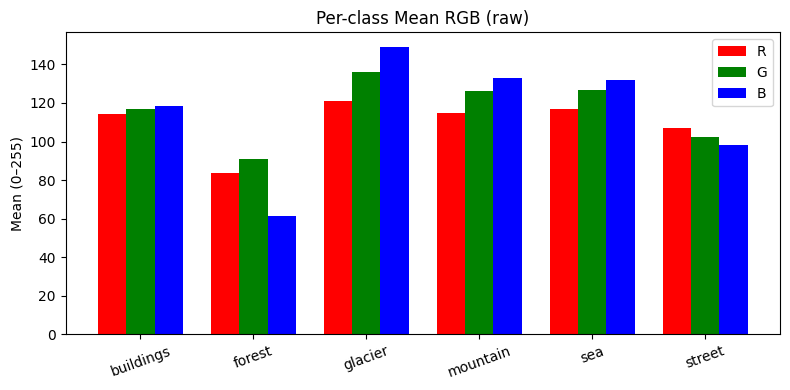

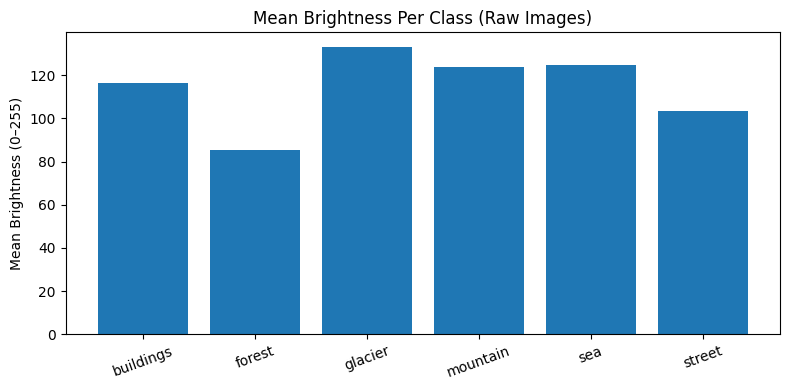

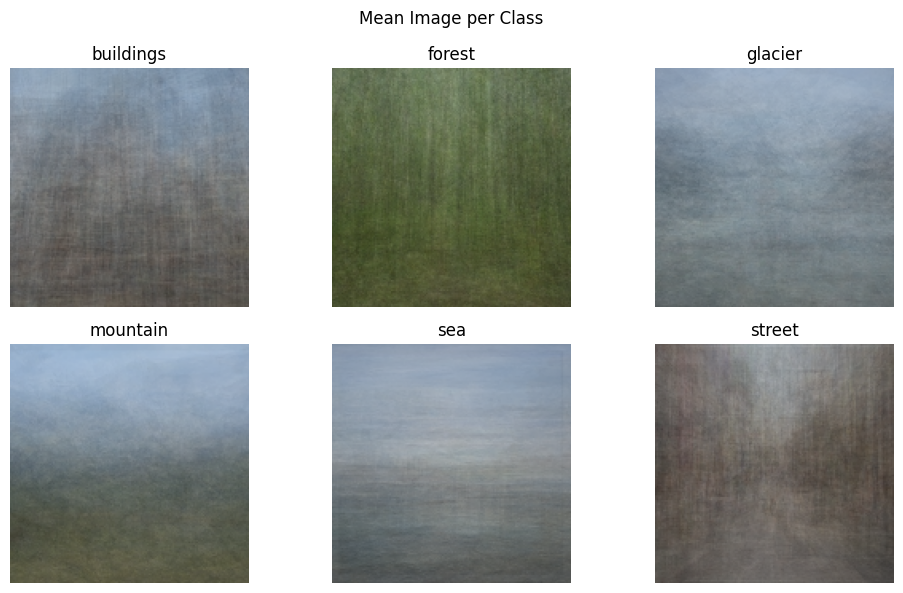

In [ ]:
# Per-class mean RGB
labels = list(per_class_mean_rgb.keys())
means_r = [per_class_mean_rgb[k][0] for k in labels]
means_g = [per_class_mean_rgb[k][1] for k in labels]
means_b = [per_class_mean_rgb[k][2] for k in labels]

x = np.arange(len(labels))
w = 0.25
plt.figure(figsize=(8,4))
plt.bar(x - w, means_r, width=w, label='R', color = "Red")
plt.bar(x,     means_g, width=w, label='G', color = "Green")
plt.bar(x + w, means_b, width=w, label='B', color = "Blue")
plt.xticks(x, labels, rotation=20)
plt.ylabel("Mean (0–255)")
plt.title("Per-class Mean RGB (raw)")
plt.legend(); plt.tight_layout();
plt.show()


# brightness Bar chart
labels = list(per_class_brightness.keys())
values = [per_class_brightness[c] for c in labels]

plt.figure(figsize=(8,4))
plt.bar(labels, values,)
plt.ylabel("Mean Brightness (0–255)")
plt.title("Mean Brightness Per Class (Raw Images)")
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()


# mean image per class

plt.figure(figsize=(10,6))
for i, cls in enumerate(per_class_mean_rgb.keys()):
    class_dir = os.path.join(DATA_DIR, cls)
    files = os.listdir(class_dir)[:50]  # first 50 images

    acc = None
    for fname in files:
        img = Image.open(os.path.join(class_dir, fname)).convert("RGB").resize((150,150))
        arr = np.asarray(img, dtype=np.float32)
        acc = arr if acc is None else acc + arr

    mean_img = (acc / len(files)).astype(np.uint8)

    plt.subplot(2, 3, i+1)
    plt.imshow(mean_img)
    plt.title(cls)
    plt.axis("off")

plt.suptitle("Mean Image per Class")
plt.tight_layout()
plt.show()



# Import and data preprocessing

In [ ]:
# Create an ImageDataGenerator object for training data.
# This defines how images will be processed and augmented before being fed into the model

train_datagen = ImageDataGenerator(
  # Create an ImageDataGenerator object for training data.
  # This defines how images will be processed and augmented before being fed into the model

  # All pixel values divided by 255 to map them into the [0,1] range.
    rescale=1./255,

  # Rotate images to prevent overfitting, 20 chosen to preserve image realism,
  # gives new perspective on data each epoch
   rotation_range=20,

  # Altering zoom range allows CNN to recognise images at variable scale
   zoom_range=0.2,

  # randomly flip data to prevent overfitting
   horizontal_flip=True,

  # split data into training and validation sets for checking for overfitting during training
    validation_split=0.2
)

# The flow_from_directory() method is used to:
# Read images directly from a directory structure
# Apply preprocessing and augmentation from train_datagen
# Batch the data
# Automatically assign class labels based on folder names

train_gen = train_datagen.flow_from_directory(
  '/content/seg_train/seg_train',

    # shrink images and standardise size
    target_size=(150,150),

    # define minibatch size
    batch_size=32,

    # data is categotical
    class_mode='categorical',

    # From the folder /content/seg_train,
    # use only the subset of images assigned to the training split.
    subset='training'
)

#does the same as above but for validation data

val_gen = train_datagen.flow_from_directory(
    '/content/seg_train/seg_train',
    target_size=(150,150),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

# as test data should be untouched by the data augmentation test_gen gets its own ImageDataGenerator
# with only rescaling applied for consistency.
test_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
    '/content/seg_test/seg_test',
    target_size=(150,150),
    batch_size=32,
    class_mode='categorical',

    # so predicted labels can match true labels
    shuffle=False
)


Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


# Define model

In [ ]:
# hyperparamaters
weightDecay = 1e-4 #

# Our VGGlike model
model = Sequential([

    # block 1 - characteristic VGG set up, 2 Convutaitonal layers followed by max pooling, additions being kernal regulisation and batchnorm.

    Conv2D(32, (3, 3), padding='same', # generic convutational layer following VGG norms, 3x3 kernal, 32 filters used (standard vgg layer 1 uses 64)
      kernel_initializer='he_normal', # VGG standard weight initialise, specifically designed for ReLu
       kernel_regularizer=regularizers.l2(weightDecay), #kernel regulariser adds L2 penalty (weight decay) to reduce overfitting
       input_shape=(150, 150, 3)), #input shape matches the image size and has 3 channels for R,G,B
    BatchNormalization(), # batch normalisation not a feature of original VGG but applied here as has been norm post 2015 to help stabilise training
    Activation('relu'), # relu activation function introduces non-linearity and helps prevent vanishing gradients
    Conv2D(32, (3,3), padding='same', # padding (also applied above) is used to prevent reduction in spatial dimensions after convolution,
          kernel_initializer='he_normal',
          kernel_regularizer=regularizers.l2(weightDecay)),
    BatchNormalization(),
    Activation('relu'),

    MaxPooling2D((2, 2)), # MaxPooling2D downsamples the feature map by taking the maximum value over each 2x2 region, reducing spatial dimensions

    # block 2 - same as above, Conv2D now uses 64 filters

    Conv2D(64, (3, 3), padding='same', # doubling filters to 64 should increase feature richness
        kernel_initializer='he_normal',
        kernel_regularizer=regularizers.l2(weightDecay)),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(64, (3,3), padding='same',
           kernel_initializer='he_normal',
           kernel_regularizer=regularizers.l2(weightDecay)),
    BatchNormalization(),
    Activation('relu'),

    MaxPooling2D((2, 2)),

    # block 3 same as above, Conv2D now uses 128 filters

    Conv2D(128, (3, 3), padding = 'same', # doubling filters again should increase feature richness and is standard for VGG
           kernel_initializer='he_normal',
           kernel_regularizer=regularizers.l2(weightDecay)),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(128, (3,3), padding='same',
           kernel_initializer='he_normal',
           kernel_regularizer=regularizers.l2(weightDecay)),
    BatchNormalization(),
    Activation('relu'),

    MaxPooling2D((2, 2)),

    # In standard VGGs 3 fully connected layers are utilised here along with flatten(), we replaced this with a globalaveragepooling2d()
    # and 2 fully connected layers to massively reduce the number of parameters, improve generalisation, and prevent overfitting considering the smaller dataset
    # and the limitations in GPU.

    GlobalAveragePooling2D(),

    Dense(512,
        kernel_initializer='he_normal',
        kernel_regularizer=regularizers.l2(weightDecay)), # fully connected layer with 512 neurons, includes L2 regularisation
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.3), # randomly deactivates 30% of neurons during training to reduce overfitting
    Dense(6, activation='softmax')  # Output layer with 6 units for 6 classes, softmax outputs class probabilities
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=1e-3), # Adam optimiser with a learning rate of 1e-3 for adaptive gradient updates
    loss=CategoricalCrossentropy(label_smoothing=0.05), ##categorical cross-entropy with label smoothing to reduce overconfidence
    metrics=['accuracy']) #accuracy used as the performance metric

# Print the model summary
model.summary()



Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 150, 150, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_14 (Activation)      │ (None, 150, 150, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 150, 150, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_15 (Activation)      │ (None, 150, 150, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_16 (Activation)      │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 75, 75, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_17 (Activation)      │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 37, 37, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 37, 37, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_18 (Activation)      │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 37, 37, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 37, 37, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_19 (Activation)      │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 128)            │             

 Total params: 359,974 (1.37 MB)

 Trainable params: 358,054 (1.37 MB)

 Non-trainable params: 1,920 (7.50 KB)

# Train and Access

In [ ]:
# Callbacks
callbacks = [
    EarlyStopping(
        monitor='val_loss',      # monitor validation loss for early stopping
        patience=8,              # stop if val_loss hasn't improved in 8 epochs
        restore_best_weights=True # restore the weights from the epoch with the best val_loss
    ),
    ModelCheckpoint(
        filepath='best_vggbn_lite_model.keras',   # filename for best model
        monitor='val_loss',                       # monitor validation loss to determine "best" model
        save_best_only=True                       # only save the model if val_loss improves
    ),

    ReduceLROnPlateau(
        monitor='val_loss',      # monitor validation loss for learning rate adjustment
        factor=0.5,              # reduce LR by half on plateau
        patience=4,              # wait 4 epochs before reducing LR
        verbose=1                # print lr updates to console when training
    )
]

# training

history = model.fit(
    train_gen,                   # ImageDataGenerator feeds the batches of augmented training data
    validation_data=val_gen,     # validation generator
    epochs=50,                   # train for 30 epochs
    callbacks=callbacks,         # apply the callbacks wrote above
    verbose=1                    # show training progress
)


Epoch 1/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 92s 235ms/step - accuracy: 0.5320 - loss: 1.4162 - val_accuracy: 0.4465 - val_loss: 1.9565 - learning_rate: 0.0010
Epoch 2/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 71s 202ms/step - accuracy: 0.7136 - loss: 0.9547 - val_accuracy: 0.6687 - val_loss: 1.1352 - learning_rate: 0.0010
Epoch 3/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 70s 200ms/step - accuracy: 0.7597 - loss: 0.8381 - val_accuracy: 0.6605 - val_loss: 1.2064 - learning_rate: 0.0010
Epoch 4/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 71s 202ms/step - accuracy: 0.7843 - loss: 0.7755 - val_accuracy: 0.6245 - val_loss: 1.2563 - learning_rate: 0.0010
Epoch 5/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 71s 201ms/step - accuracy: 0.7931 - loss: 0.7410 - val_accuracy: 0.6658 - val_loss: 1.1065 - learning_rate: 0.0010
Epoch 6/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 71s 203ms/step - accuracy: 0.8163 - loss: 0.6798 - val_accuracy: 0.7561 - val_loss: 0.8296 - learning_rate: 0.0010
Epoch 7/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 71s 202ms/step - accuracy: 0.8

In [ ]:
test_loss, test_acc = model.evaluate(test_gen) # evaluate model performance on the test set
print(f"Test Accuracy: {test_acc:.3f}")

94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.9069 - loss: 0.3682
Test Accuracy: 0.888


# Visualise Model results

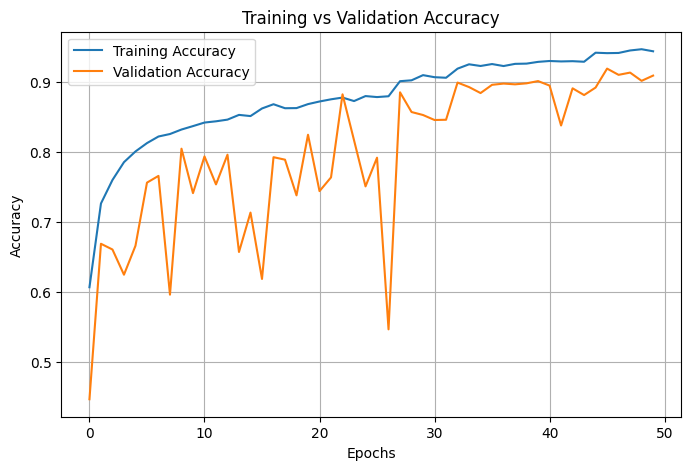

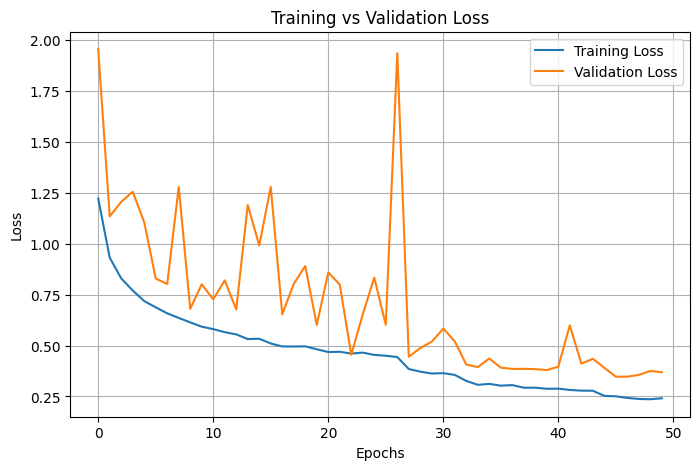

94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step

Classification Report:

              precision    recall  f1-score   support

   buildings       0.84      0.93      0.88       437
      forest       0.98      0.97      0.98       474
     glacier       0.88      0.80      0.84       553
    mountain       0.82      0.86      0.84       525
         sea       0.88      0.94      0.91       510
      street       0.94      0.85      0.90       501

    accuracy                           0.89      3000
   macro avg       0.89      0.89      0.89      3000
weighted avg       0.89      0.89      0.89      3000



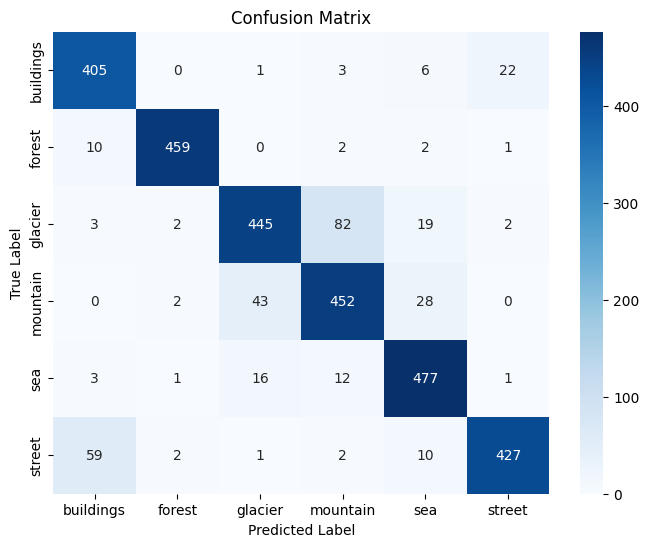

In [ ]:
# training vs val accuracy plot

plt.figure(figsize=(8,5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# training vs val loss plot

plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


# classification report

y_pred = model.predict(test_gen, verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_gen.classes
class_labels = list(test_gen.class_indices.keys())


print("\nClassification Report:\n")
print(classification_report(y_true, y_pred_classes, target_names=class_labels))

# confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
